# Checking simulation parameters, and the quality of simulation
- Energy and pressure plots
- Distance between periodic images


In [3]:
#Libraries and main variables initialized
import MDAnalysis as mda
from MDAnalysis.analysis import align
from MDAnalysis.analysis.rms import rmsd
import numpy as np
import urllib.request, json
import os
import re
import nglview as nv
from funcs import get_files_from_git
from funcs import view_nucl
import panedr
import matplotlib.pyplot as plt

#Reloading funcs if changed
from importlib import reload 
import funcs,config
reload(funcs)
reload(config)

import xvg_plot as xvg
import xpm_plot as xpm



%matplotlib inline
from IPython.display import Markdown, display
from config import folder,descr,pname
display(Markdown(descr))
print("Folder set to: ",folder)
print("Project name: ",pname)




# MD simulations of H3-H4 with 30 bp of DNA, tails truncated
- AMBER14SB force field
- 50 mM NaCl
- box 2nm


Folder set to:  h3-h4_tm_DNA
Project name:  h3-h4_tm_DNA


Quick view

In [ ]:
view_nucl('GMX_system/init_solv_ions.pdb','GMX_run/7_prod.xtc')

## QC analysis
### Let's look at energy, temperature pressure
#### First 1000 steps

Last Frame read : 132622, time : 265242.0 ps
132622 frame read in 53.72 seconds


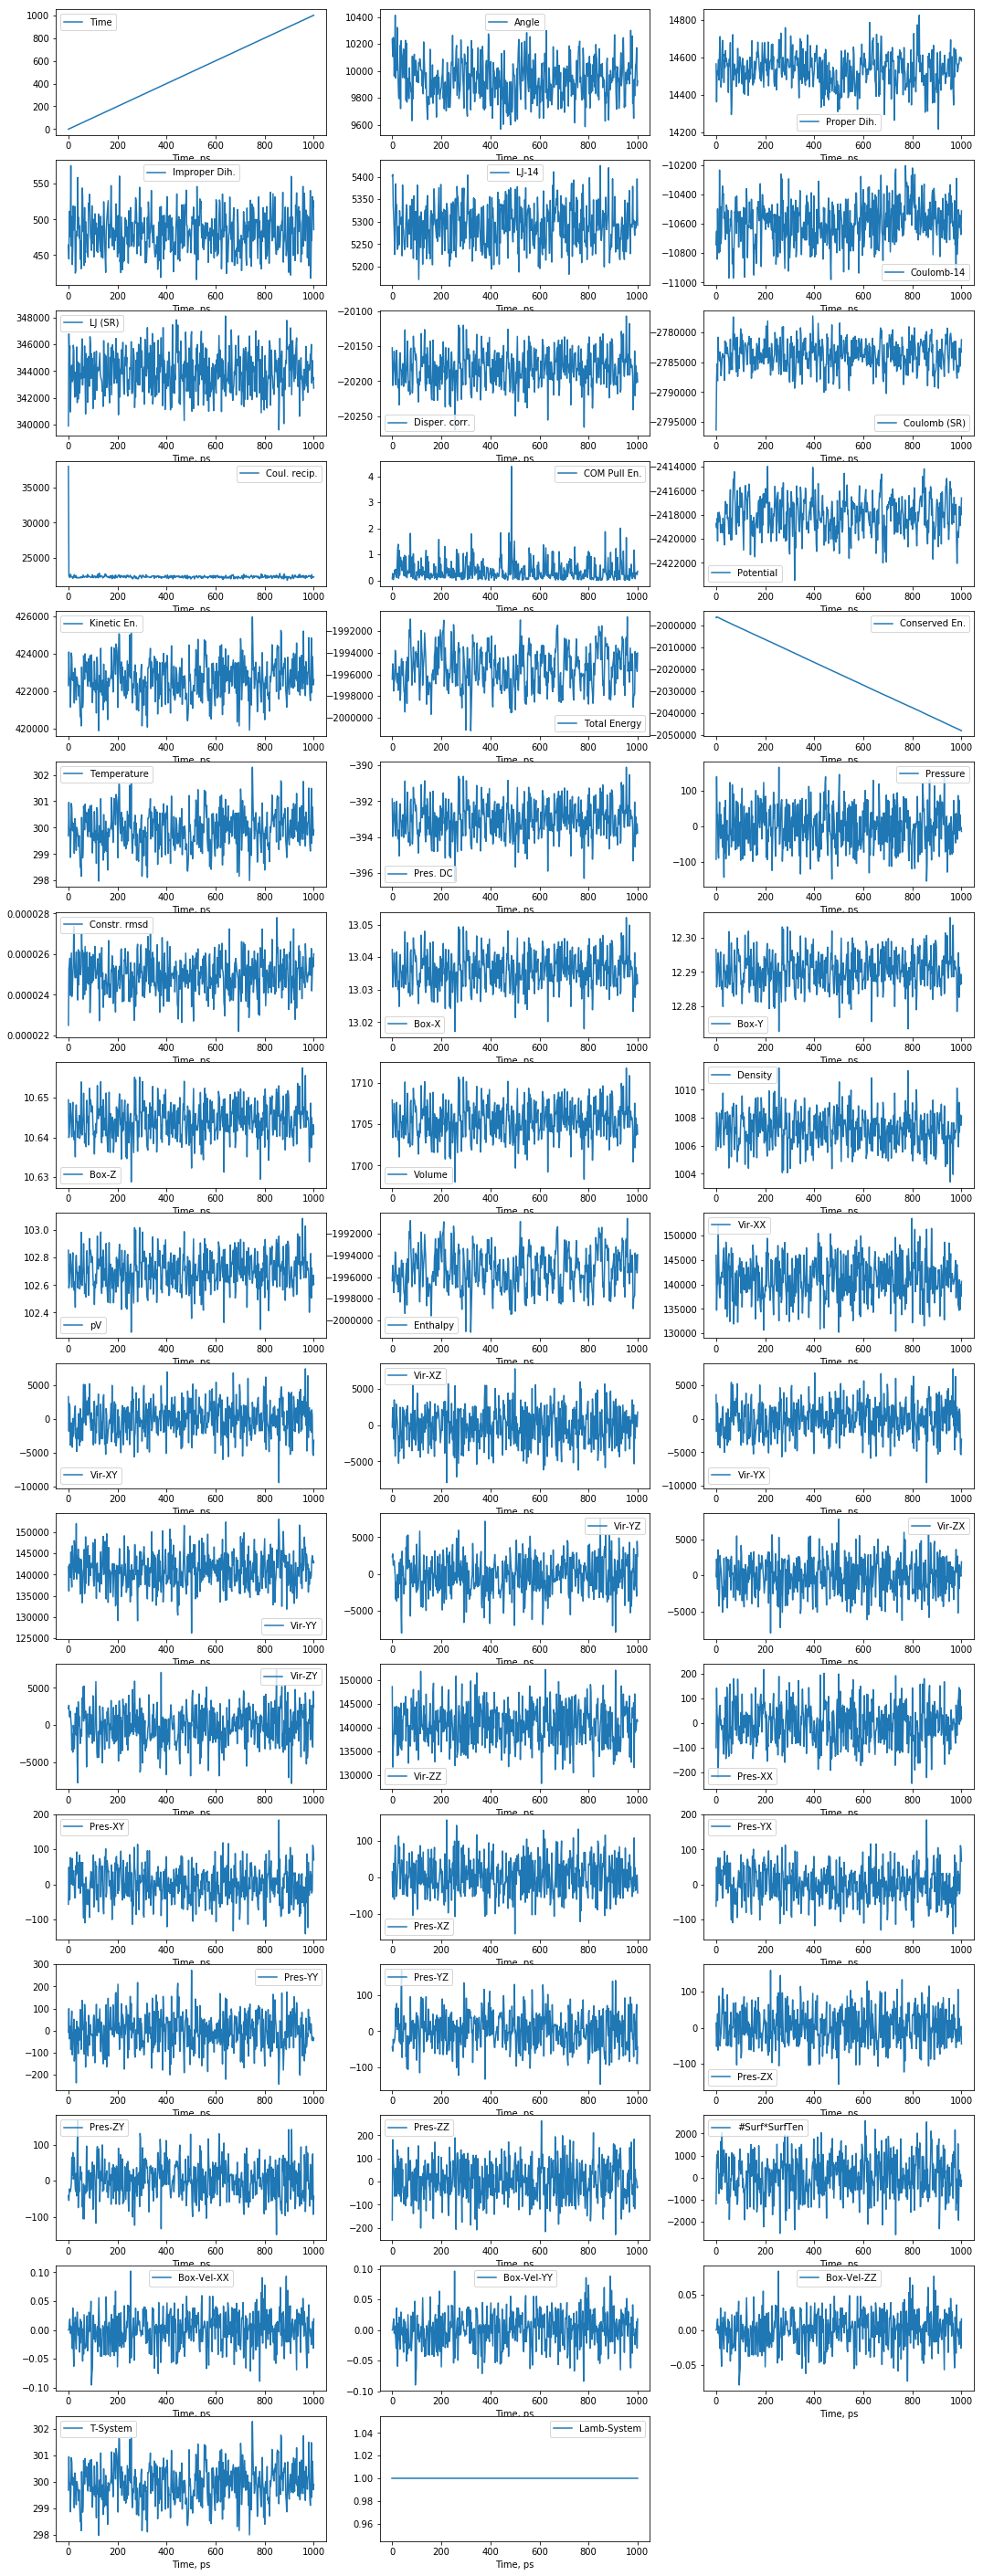

In [4]:
df = panedr.edr_to_df('GMX_run/7_prod.edr', verbose=True)
num_of_keys=len(df.keys())
grid=[1+num_of_keys//3,3]

plt.figure(figsize=(grid[1]*6,grid[0]*3))
plt.title('Mod')
for i,key in enumerate(df.keys(),1):
    ax=plt.subplot(*grid, i)
    ax.plot(df[key][0:1000],label=key)
    ax.set_xlabel('Time, ps')
    ax.legend()    
plt.show()

#### All trajectory, every 1000 step

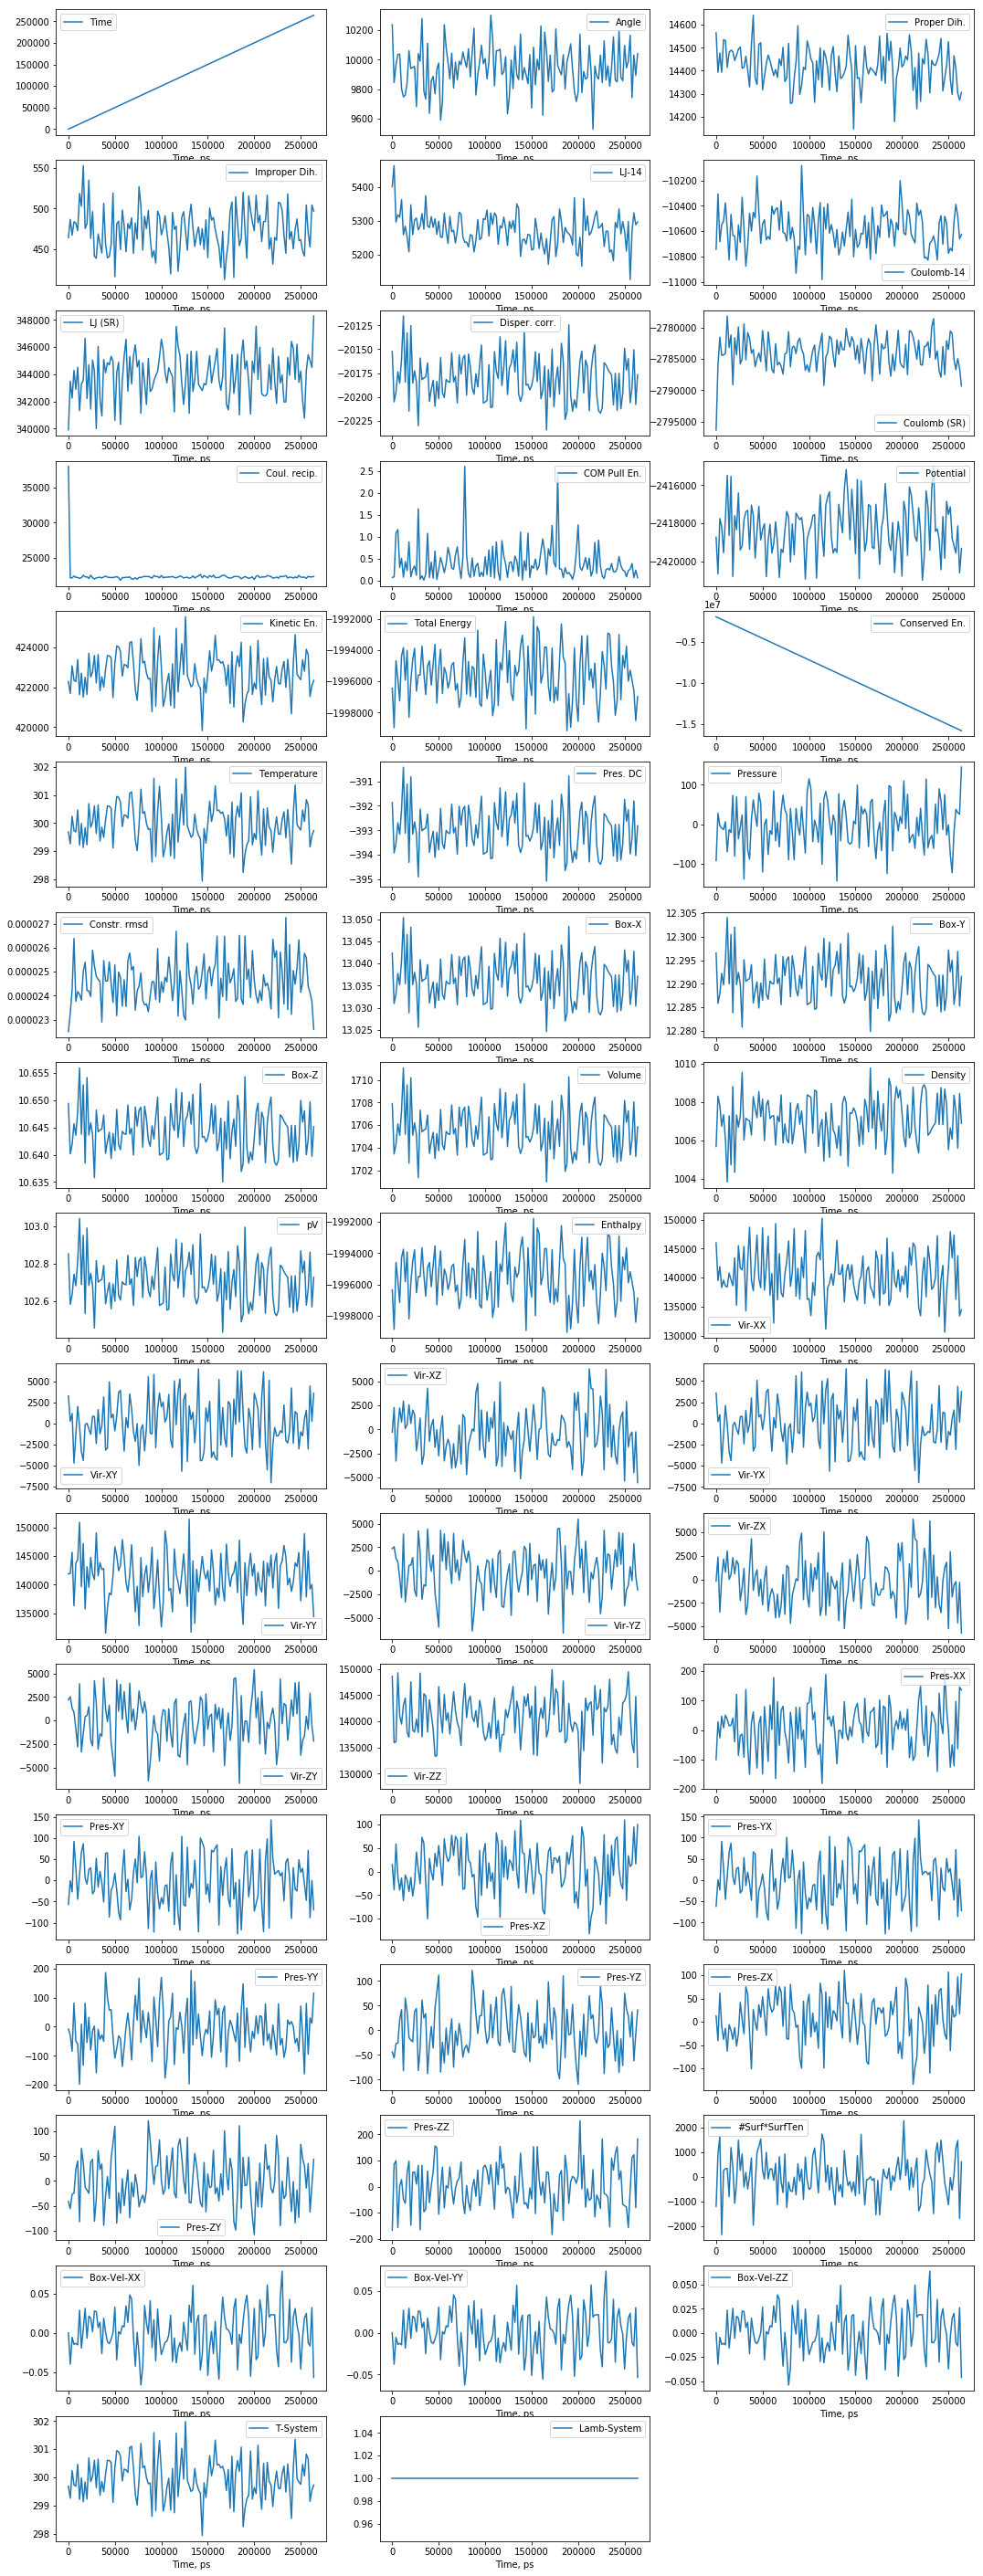

In [5]:
step=1000 #plot every 1000 records

plt.figure(figsize=(grid[1]*6,grid[0]*3))
plt.title('Mod')
for i,key in enumerate(df.keys(),1):
    ax=plt.subplot(*grid, i)
    ax.plot(df[key][0::step],label=key)
    ax.set_xlabel('Time, ps')
    ax.legend()    
plt.show()

### Checking periodic images
- We need to check if there are problems in periodic image interactions
- http://manual.gromacs.org/documentation/2018/onlinehelp/gmx-mindist.html

Our initial box vectors of a truncated octahedron are
gro-file notation
10.23860   9.65312   8.36010   0.00000   0.00000   3.41266   0.00000  -3.41266   4.82612
 ax          by        cz        ay         az         bx       by        cx        cy
     a    b   c  
 x   ax   bx  cx  | d    d/3            -d/3      
 y   ay   by  cy  | 0    d*2*sqrt(2)/3  d*sqrt(2)/3
 z   az   bz  cz  | 0    0              d*sqrt(6)/3 

In [6]:
%%bash
mkdir -p big_data
#gmx mindist -n GMX_system/index.ndx -f GMX_run/7_prod.xtc -s GMX_run/7_prod.tpr -od big_data/mindist.xvg -pi -dt 10000 << !
#gmx mindist -n GMX_system/index.ndx -f GMX_run/7_prod.xtc -s GMX_run/7_prod.tpr -od big_data/mindist.xvg -pi -dt 10000 << !
gmx mindist -n GMX_system/index.ndx -f tmp/7_prod_2.xtc -s GMX_run/7_prod.tpr -od big_data/mindist.xvg -pi -dt 10000 << !
!Water_and_ions
!

Selected 22: '!Water_and_ions'

The shortest periodic distance is 3.97017 (nm) at time 200000 (ps),
between atoms 5 and 955


                     :-) GROMACS - gmx mindist, 2018.4 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar    Aldert van Buuren   Rudi van Drunen     Anton Feenstra  
  Gerrit Groenhof    Aleksei Iupinov   Christoph Junghans   Anca Hamuraru   
 Vincent Hindriksen Dimitrios Karkoulis    Peter Kasson        Jiri Kraus    
  Carsten Kutzner      Per Larsson      Justin A. Lemkul    Viveca Lindahl  
  Magnus Lundborg   Pieter Meulenhoff    Erik Marklund      Teemu Murtola   
    Szilard Pall       Sander Pronk      Roland Schulz     Alexey Shvetsov  
   Michael Shirts     Alfons Sijbers     Peter Tieleman    Teemu Virolainen 
 Christian Wennberg    Maarten Wolf   
                           and the project leaders:
        Mark Abraham, Berk Hess, Erik Lindahl, and David van der Spoel

Copyright (c) 1991-2000, University of Groningen, The Netherlands.
Copyright (c) 2001-2017, The GROMACS de

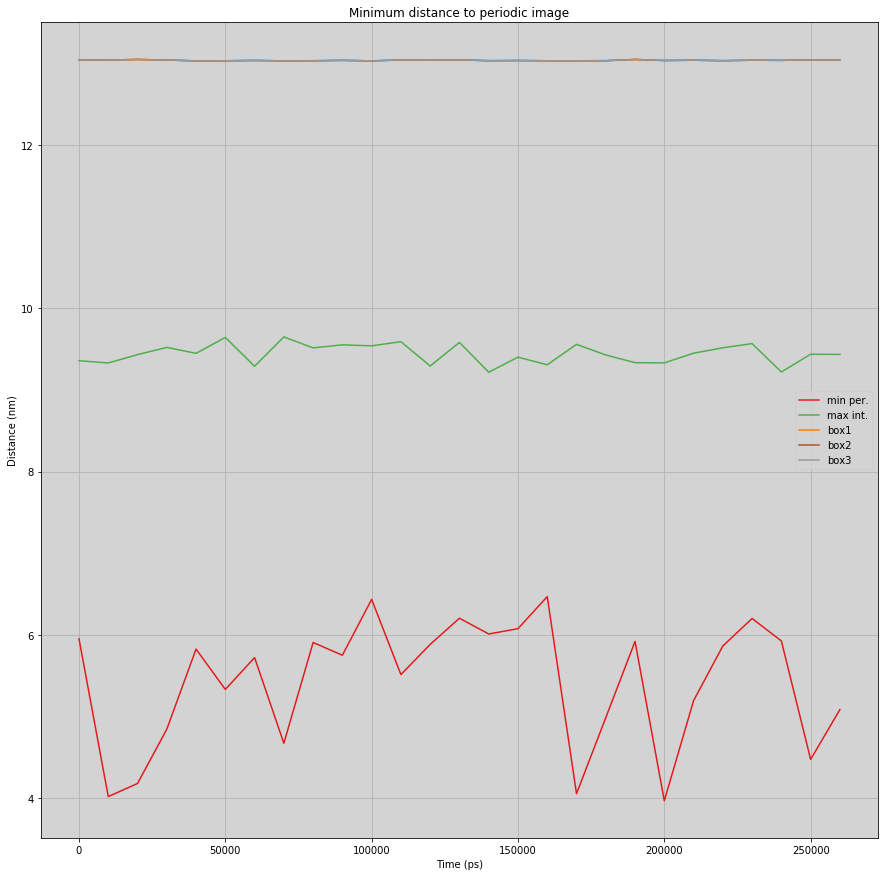

In [7]:
#With option -pi the minimum distance of a group to its periodic image is plotted. 
#This is useful for checking if a protein has seen its periodic image during a simulation.
#Only one shift in each direction is considered, giving a total of 26 shifts.
#It also plots the maximum distance within the group and the lengths of the three box vectors.

metadata, data = xvg.parse_xvg('big_data/mindist.xvg', 'all')
data=np.array(data)
#data=data[:,0:10]
xvg.plot_data(data, metadata,figsize=(15,15))